## 모두컴퍼니 사용자 이용 건수 DB EDA

### &#9989; 분석 배경
- 이용자 별 향후 이용 건수를 예측하여 마케팅, 영업 등의 의사 결정 과정에 활용 
-----
### &#9989; EDA 요약

- 요약 예정

### &#10010; EDA 상세

#### Import 모듈

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Hierarchical clustering
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

#### PC 세팅

In [2]:
%matplotlib inline
sns.set_style("white")
sns.set()

# (Windows OS) 한글 출력을 위한 글꼴 설정
#plt.rcParams['font.family'] = 'MalgunGothic'  
# (MAC OS)
plt.rcParams['font.family'] = 'AppleGothic'  
# 문자 - (마이너스) 정상 출력을 위한 코드
plt.rcParams['axes.unicode_minus'] = False
# 경고 제거
plt.rcParams.update({'figure.max_open_warning': 0})
# 노트북 세팅
pd.options.display.float_format = '{:.2f}'.format

#### 데이터 Read 및 date 컬럼 datetime 타입으로 변경

In [3]:
# 데이터 파일 read (각자의 경로 입력)
user_df=pd.read_csv('/Users/jaehwan/Desktop/송재환/DS_Project/모두컴퍼니_기술과제/실전db.csv', encoding='cp949')

user_df.columns = user_df.columns.str.lower()
user_df.join_date = pd.to_datetime(user_df.join_date)
user_df.date = pd.to_datetime(user_df.date)
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879271 entries, 0 to 879270
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     879271 non-null  int64         
 1   join_date   879271 non-null  datetime64[ns]
 2   d_type      879271 non-null  object        
 3   store_id    879271 non-null  int64         
 4   goods_type  879271 non-null  object        
 5   date        879271 non-null  datetime64[ns]
 6   count       879271 non-null  int64         
 7   ad1         879271 non-null  object        
dtypes: datetime64[ns](2), int64(3), object(3)
memory usage: 53.7+ MB


### 사용자 일별 이용 건수 확인

In [4]:
# 사용자 일별 이용 건수
np.sort(user_df['count'].unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       53, 55, 58, 59, 61])

### &#10145; 이용자별 이용 건수의 전반적인 분포 확인을 위한 히스토그램
- 1회 이용 이용자가 압도적으로 많기 때문에 전체적인 내용 확인을 위해 값에 log를 적용

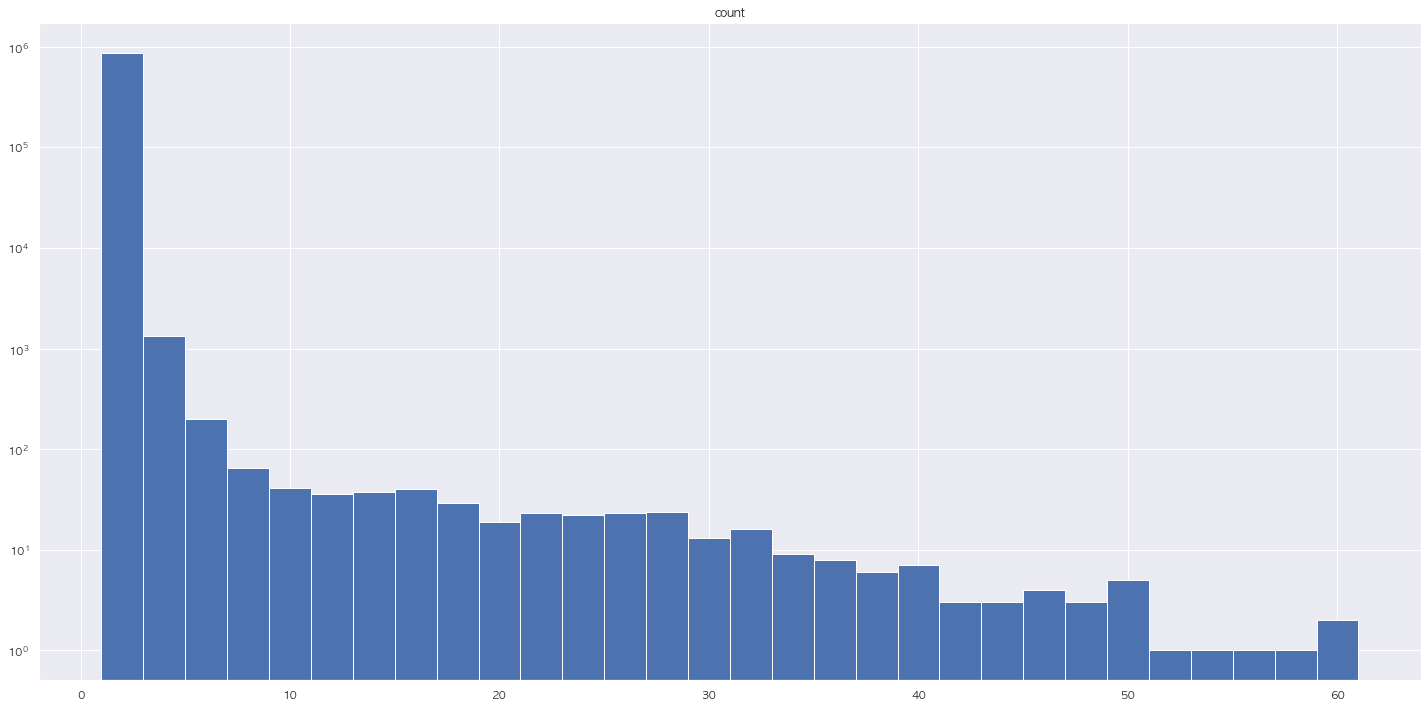

In [5]:
user_df.hist(bins=30, column=['count'],
                   figsize=(20,10), layout=(1,1),log=True);
plt.tight_layout()

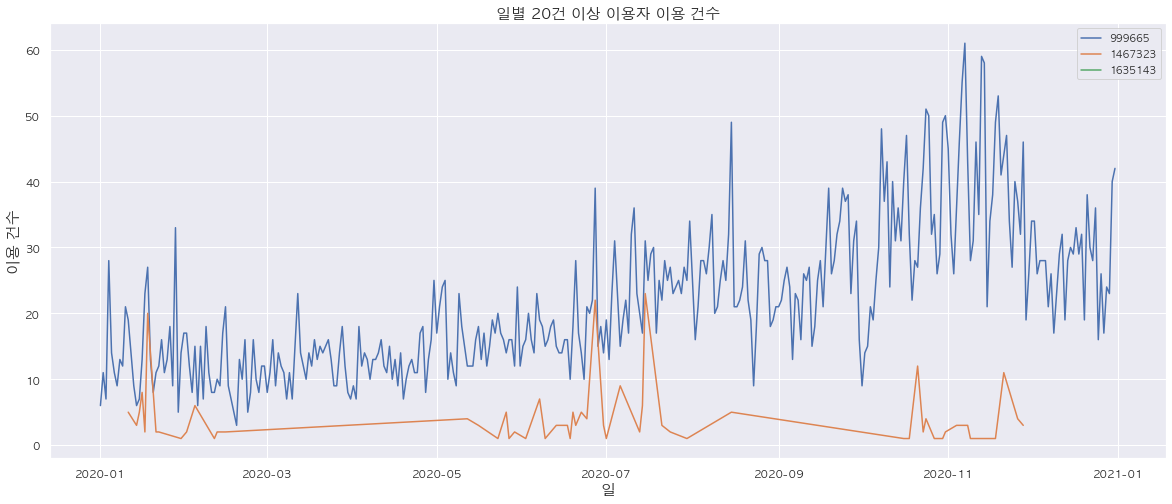

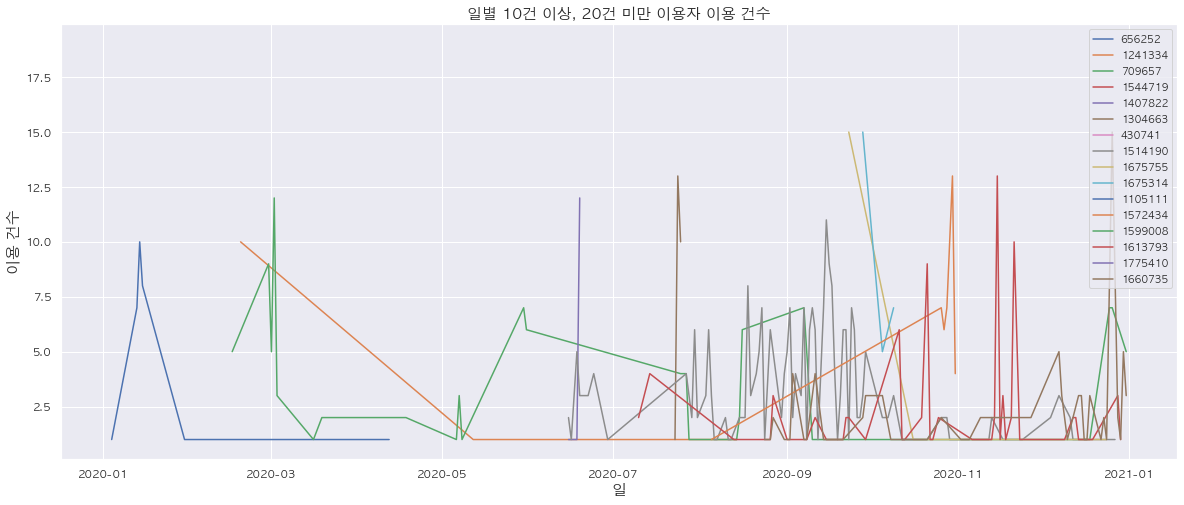

In [6]:
# 일별 20회 이상 이용 건수를 기록한 이용자 추출
heavy_user = []

for i in user_df[user_df['count'] >= 20]['user_id'].unique():
    heavy_user.append(i)
    
plt.figure(figsize=(20,8))

for j in heavy_user:
    a_user = "a_"+str(j)     
    a_user = user_df[user_df['user_id'] == j].groupby('date').sum()['count']
    
    sns.lineplot(a_user.index, a_user.values)
        
plt.title('일별 20건 이상 이용자 이용 건수', fontsize=15)
plt.legend(heavy_user, loc='best', fontsize=10)
plt.ylabel('이용 건수', fontsize=15)
plt.xlabel('일', fontsize=15)

# 일별 10회 이상 20회 미만 이용 건수를 기록한 이용자 추출
middle_user = []

for i in user_df[(user_df['count'] >= 10) & (user_df['count'] < 20)]['user_id'].unique():
    middle_user.append(i)
    
    if i in [999665, 1467323, 1635143]:
        middle_user.remove(i)
        
plt.figure(figsize=(20,8))

for j in middle_user:
    a_user = "a_"+str(j)     
    a_user = user_df[user_df['user_id'] == j].groupby('date').sum()['count']
    
    sns.lineplot(a_user.index, a_user.values)
        
plt.title('일별 10건 이상, 20건 미만 이용자 이용 건수', fontsize=15)
plt.legend(middle_user, loc='best', fontsize=10)
plt.ylabel('이용 건수', fontsize=15)
plt.xlabel('일', fontsize=15)
plt.show()

#### 일별 20회 이상 이용자는 이용에서 정기적인 이용 패턴이 확인되나, 그 미만 사용자는 이용 내역이 모두 상이하게 확인된다.<br>대부분의 경우가 20회 미만 사용자임을 고려하면, 보편적인 예측을 위해 heavy_user는 제외 처리 한다.

In [7]:
filtered_df = user_df.copy()

for i in heavy_user:
    filtered_df = filtered_df[filtered_df['user_id'] != i].reset_index().drop('index',axis=1)
 
filtered_df.sort_values('count', ascending=False)

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1
208310,1544719,2020-04-17,BB,221045,A,2020-04-18,19,GN
756817,1775410,2020-11-14,BB,92505,A,2020-11-15,17,J
865945,1660735,2020-08-18,BB,90444,A,2020-12-26,15,GN
733905,1599008,2020-06-17,BB,203847,A,2020-11-08,15,SC
618579,1675314,2020-09-01,BB,109670,A,2020-09-28,15,CY
...,...,...,...,...,...,...,...,...
295265,1574936,2020-05-21,AA,109421,A,2020-05-27,1,J
295266,1574993,2020-05-22,BB,182009,A,2020-05-27,1,J
295267,1575044,2020-05-22,BB,220700,A,2020-05-27,1,GN
295268,1575054,2020-05-22,BB,91853,D,2020-05-27,1,YD


#### EDA를 위한 추가 컬럼 생성

In [8]:
# 데이터 파일 read (각자의 경로 입력)
holiday_df=pd.read_excel('/Users/jaehwan/Desktop/송재환/DS_Project/모두컴퍼니_기술과제/holiday_master.xlsx', encoding='cp949')
holiday_df.date = pd.to_datetime(holiday_df.date)

filtered_df = pd.merge(filtered_df, holiday_df, on='date', how='left')
filtered_df

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1,isholiday,exp
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN,holiday,새해
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J,holiday,새해
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC,holiday,새해
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP,holiday,새해
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR,holiday,새해
...,...,...,...,...,...,...,...,...,...,...
878841,1830551,2020-12-31,BB,219886,B,2020-12-31,1,GN,weekdays,NaN
878842,1830570,2020-12-31,BB,82433,B,2020-12-31,1,CY,weekdays,NaN
878843,1830580,2020-12-31,AA,92020,B,2020-12-31,1,JRR,weekdays,NaN
878844,1830589,2020-12-31,BB,92437,B,2020-12-31,1,J,weekdays,NaN


In [9]:
filtered_df['month'] = filtered_df.date.dt.month
filtered_df['week'] = filtered_df.date.dt.week
filtered_df['weekday'] = filtered_df.date.dt.weekday
filtered_df['주중/주말'] = filtered_df['weekday'].map(lambda x: '주말' if x > 4 else '주중')
filtered_df['day_name'] = filtered_df.date.dt.day_name().str.slice(start=0, stop=3)
filtered_df.head()

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1,isholiday,exp,month,week,weekday,주중/주말,day_name
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN,holiday,새해,1,1,2,주중,Wed
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J,holiday,새해,1,1,2,주중,Wed
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC,holiday,새해,1,1,2,주중,Wed
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP,holiday,새해,1,1,2,주중,Wed
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR,holiday,새해,1,1,2,주중,Wed


#### 시계열 추이 및 타입별 구분 요약
1. 이용 건수의 합계는 증가 추이에 있다. 특히 8월을 기점으로 이용자 수가 급상승하였다.
2. 주별 이용 건수를 봤을 때, 주말에 평균 이용자 수가 더 많음을 확인할 수 있다.
3. 월~토까지 비슷한 이용자 수를 보이나, 일요일에는 이용자 수가 적음을 알 수 있다.<br>(토요일이 압도적으로 높은 건 아닌데, 왜 주별 평균은 주말이 높을까?)
4. d_type 별 이용 건수는 AA가 제일 많거, BB가 그것보다 적다.
5. goods_type 별 이용 건수는 A가 압도적으로 많다.
6. ad1 별 이용 건수는 J, GN, JRR, SC, MP, YD 순으로 많고 J와 GN, JRR이 Top 3이다.<br>(하지만 평균적인 이용자 수는 RRR이 가장 높고, 나머지는 비슷하다.

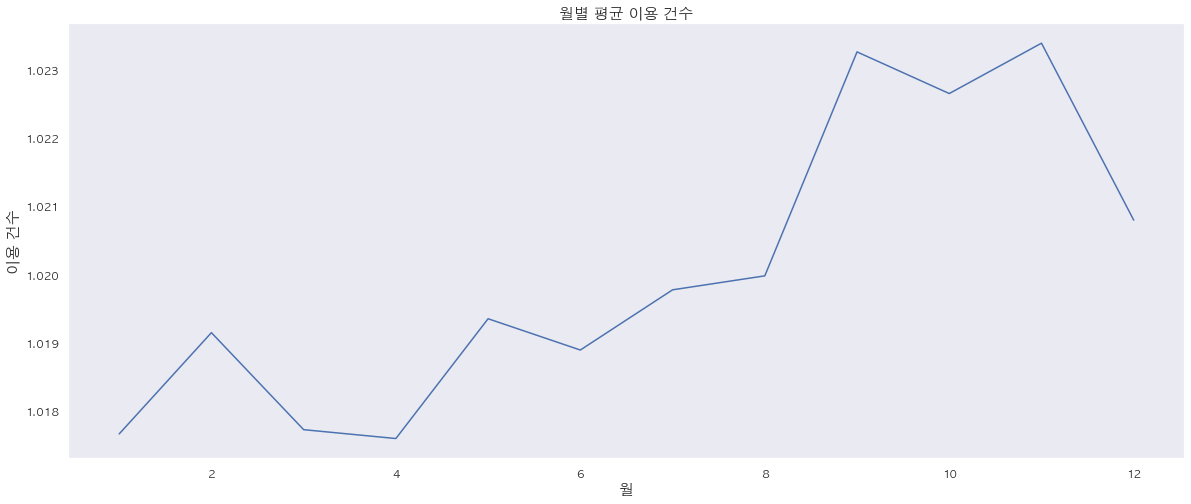

<Figure size 1440x576 with 0 Axes>

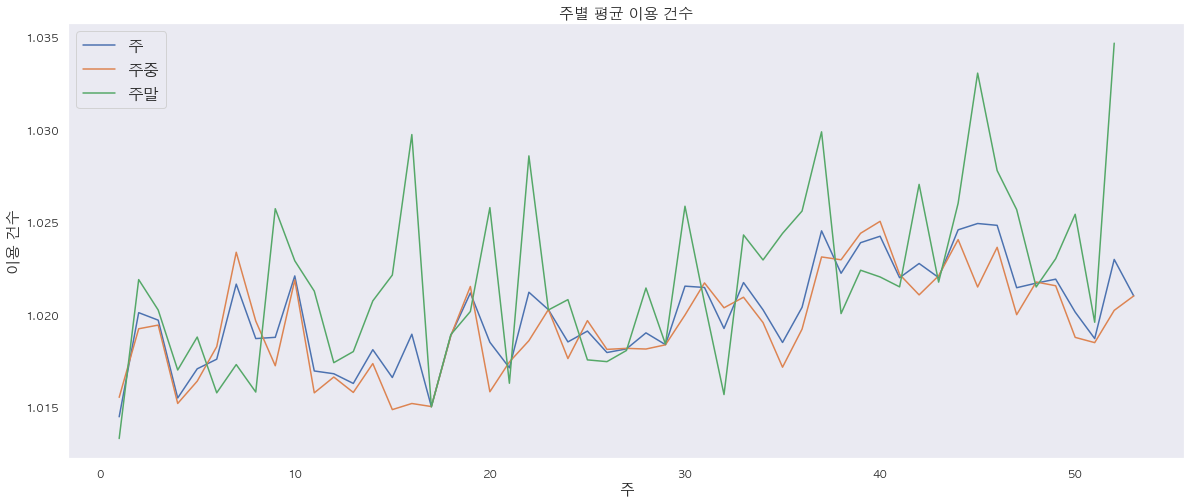

*weekday: 0(월요일)~6(일요일)


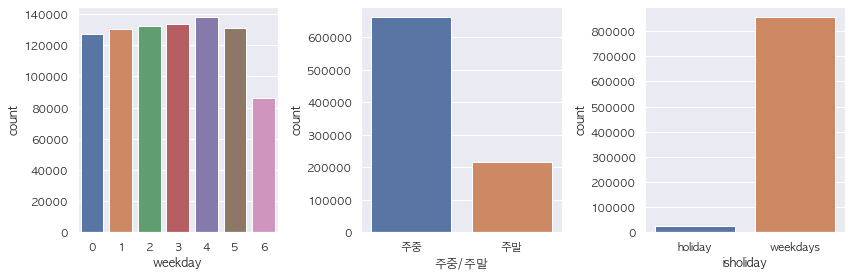

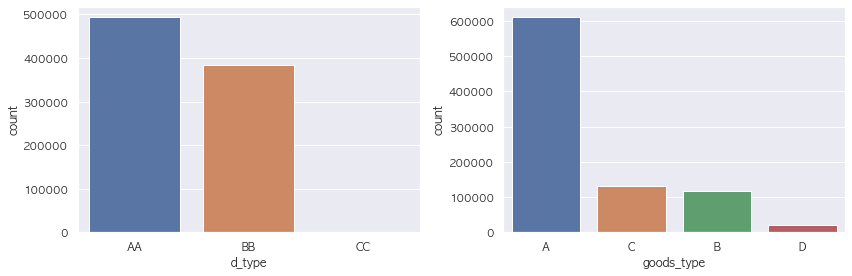

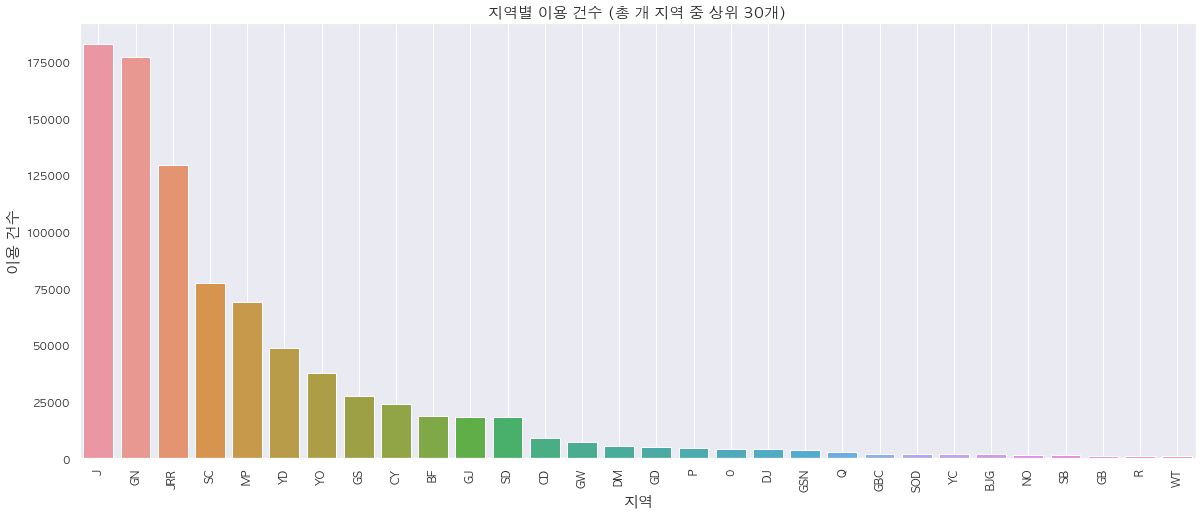

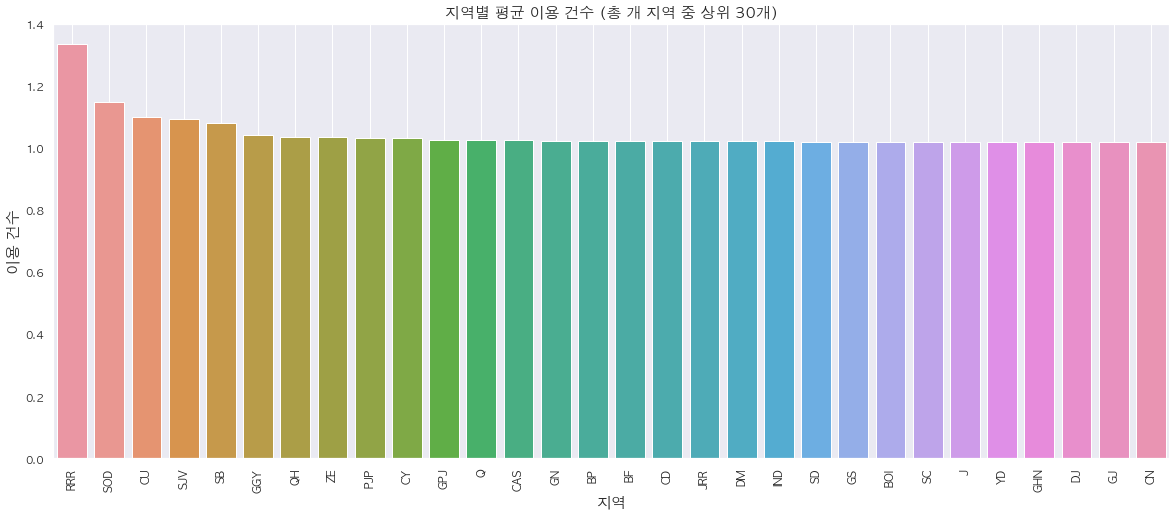

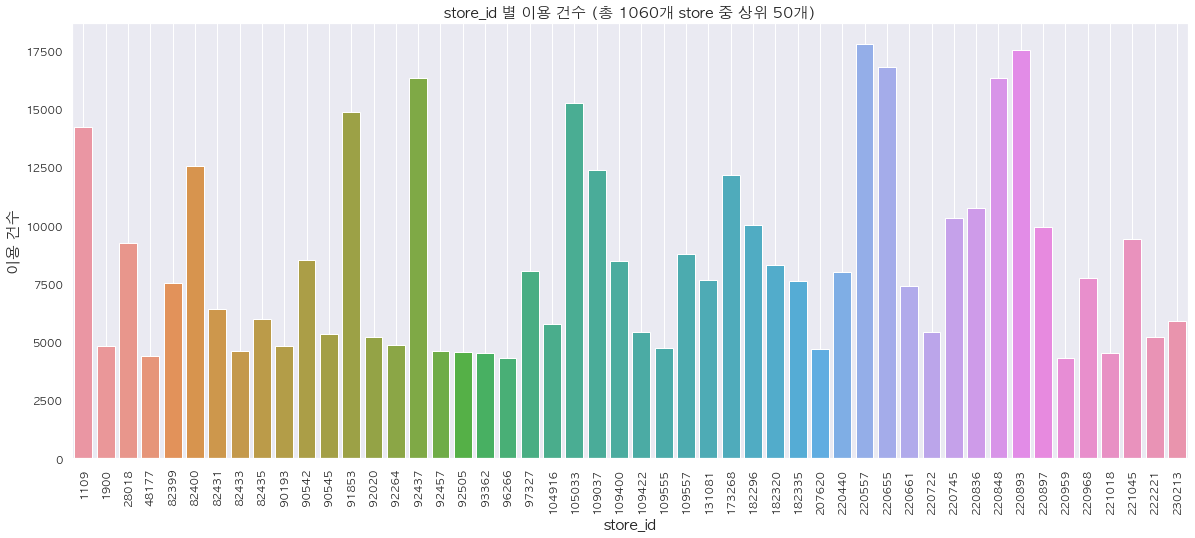

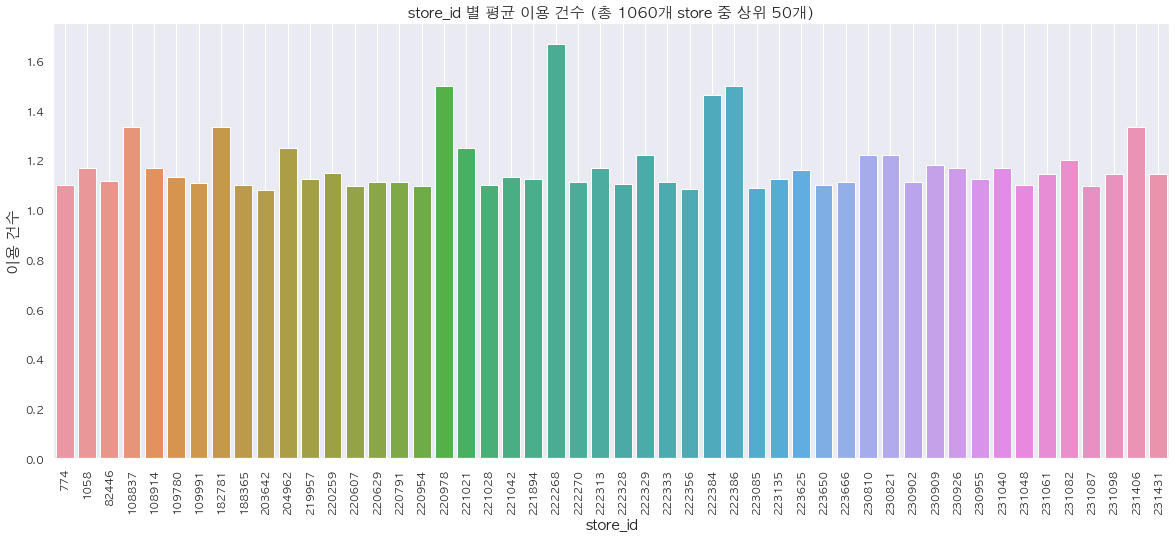

In [10]:
a = filtered_df.groupby('month').mean()
a = a['count']

plt.figure(figsize=(20,8))
sns.lineplot(a.index, a.values)
plt.grid()
plt.title('월별 평균 이용 건수', fontsize=15)
plt.ylabel('이용 건수', fontsize=15)
plt.xlabel('월', fontsize=15)
plt.show()

a = filtered_df.groupby('week').mean()
a = a['count']

a_주중 = filtered_df.loc[filtered_df['주중/주말'] == '주중', :].groupby('week').mean()
a_주중 = a_주중['count']

a_주말 = filtered_df.loc[filtered_df['주중/주말'] == '주말', :].groupby('week').mean()
a_주말 = a_주말['count']

plt.figure(figsize=(20,8))

plt.figure(figsize=(20,8))
sns.lineplot(a.index, a.values)
sns.lineplot(a_주중.index, a_주중.values)
sns.lineplot(a_주말.index, a_주말.values)
plt.grid()
plt.legend(['주', '주중', '주말'], loc='best', fontsize=16)
plt.title('주별 평균 이용 건수', fontsize=15)
plt.ylabel('이용 건수', fontsize=15)
plt.xlabel('주', fontsize=15)
plt.show()

# 추가 date 

category_cols = ['weekday','주중/주말','isholiday']

figure, ax_list_list = plt.subplots(nrows=1, ncols=3);
figure.set_size_inches(12,4)

ax_list = ax_list_list.reshape(3)  # 다차원 행렬의 차원을 원하는 모양으로 변경합니다.

print("*weekday: 0(월요일)~6(일요일)")

for i in range(len(category_cols)):
    col = category_cols[i]
    sns.countplot(data=filtered_df, x=col, ax=ax_list[i])
    # ax_list[i].set_title(col)

plt.tight_layout()

# 카테고리

category_cols = ['d_type','goods_type']

figure, ax_list_list = plt.subplots(nrows=1, ncols=2);
figure.set_size_inches(12,4)

ax_list = ax_list_list.reshape(2)  # 다차원 행렬의 차원을 원하는 모양으로 변경합니다.

for i in range(len(category_cols)):
    col = category_cols[i]
    sns.countplot(data=filtered_df, x=col, ax=ax_list[i])
    # ax_list[i].set_title(col)

plt.tight_layout()

a = filtered_df.groupby('ad1').sum()
a = pd.DataFrame(a).sort_values('count', ascending=False).head(30)

plt.figure(figsize=(20,8))
sns.barplot(a.index, a['count'])
plt.grid()
plt.title('지역별 이용 건수 (총 개 지역 중 상위 30개)', fontsize=15)
plt.ylabel('이용 건수', fontsize=15)
plt.xlabel('지역', fontsize=15)
plt.xticks(rotation=90)
plt.show()

a = filtered_df.groupby('ad1').mean()
a = pd.DataFrame(a).sort_values('count', ascending=False).head(30)

plt.figure(figsize=(20,8))
sns.barplot(a.index, a['count'])
plt.grid()
plt.title('지역별 평균 이용 건수 (총 개 지역 중 상위 30개)', fontsize=15)
plt.ylabel('이용 건수', fontsize=15)
plt.xlabel('지역', fontsize=15)
plt.xticks(rotation=90)
plt.show()

a = filtered_df.groupby('store_id').sum().sort_values('count', ascending=False)
a = pd.DataFrame(a).sort_values('count', ascending=False).head(50)

plt.figure(figsize=(20,8))
sns.barplot(a.index, a['count'])
plt.grid()
plt.title('store_id 별 이용 건수 (총 1060개 store 중 상위 50개)', fontsize=15)
plt.ylabel('이용 건수', fontsize=15)
plt.xlabel('store_id', fontsize=15)
plt.xticks(rotation=90)
plt.show()

a = filtered_df.groupby('store_id').mean().sort_values('count', ascending=False)
a = pd.DataFrame(a).sort_values('count', ascending=False).head(50)

plt.figure(figsize=(20,8))
sns.barplot(a.index, a['count'])
plt.grid()
plt.title('store_id 별 평균 이용 건수 (총 1060개 store 중 상위 50개)', fontsize=15)
plt.ylabel('이용 건수', fontsize=15)
plt.xlabel('store_id', fontsize=15)
plt.xticks(rotation=90)
plt.show()

#### 상관분석
- count와 관련된 적당한 feature를 못 찾았거나,<br>Label Encoding을 잘못했거나.

In [11]:
train_df = filtered_df[(filtered_df['date'] >= '2020-01-01') & (filtered_df['date'] < '2020-10-01')]
test_df = filtered_df[(filtered_df['date'] >= '2020-10-01')]

In [12]:
# 간단한 분류의 컬럼은 Label Encoding

from sklearn.preprocessing import LabelEncoder

i = 0 

for i in ['join_date', 'd_type', 'goods_type','주중/주말', 'isholiday']:
    le = LabelEncoder()
    le.fit(train_df[i])
    train_df[i] = le.transform(train_df[i])

<ipython-input-12-ad907e19412a>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[i] = le.transform(train_df[i])


In [13]:
# 복잡한 분류의 컬럼은 One Hot Encoding

# pd.get_dummies(data = train_df, columns = ['ad1'], prefix = 'ad1')

# ad1_list = train_df['ad1'].value_counts().index
# for ad1 in ad1_list:
    # train_df['ad1_'+f'{ad1}'] = train_df['ad1'] == ad1
 
# train_df.head()

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51452 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51473 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47568 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51452 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51473 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 47568 missing from curre

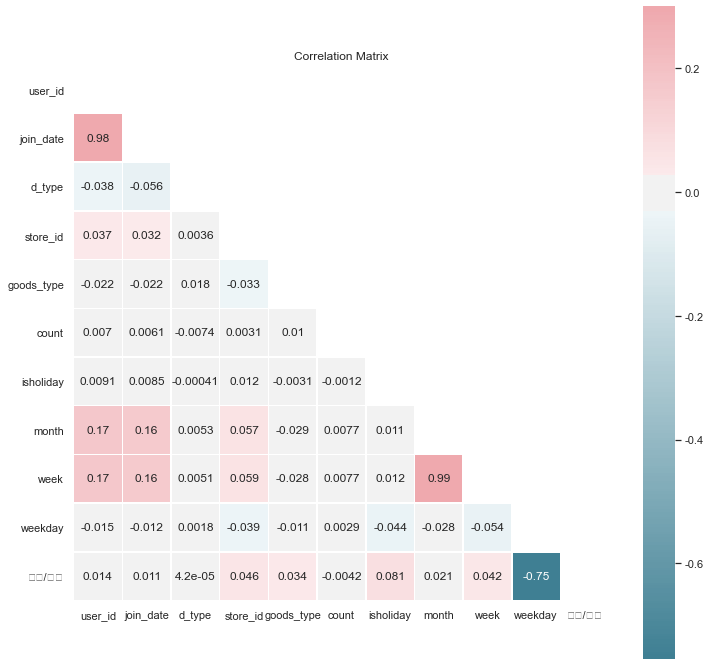

In [14]:
sns.set(style="white")
corr = train_df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(12, 12))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.title('Correlation Matrix', fontsize=12)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, annot=True)
plt.show()